In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
class Load_Dataset:
    def __init__(self, path):
        self.path = path

    def load_data(self):
        df = pd.read_csv(self.path)
        return df

In [46]:
file_name = "2025.06.16 1112 - dt-daily-usage.csv"

try:
    data_loader = Load_Dataset(file_name)
    df = data_loader.load_data()
    print("File Loaded succesfully")
    print(f"List of columns: {df.columns} ")
except FileNotFoundError as e:
    print(f"File: {file_name} not found error: {e}")

File Loaded succesfully
List of columns: Index(['Timestamp (UTC)', 'Meter Number', 'Usage Amount'], dtype='object') 


In [47]:
df['Timestamp (UTC)'] = pd.to_datetime(df['Timestamp (UTC)'])

In [48]:
df.info()
print("Total Missing values in each column")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8404 entries, 0 to 8403
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp (UTC)  8404 non-null   datetime64[ns, UTC]
 1   Meter Number     8404 non-null   int64              
 2   Usage Amount     8404 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 197.1 KB
Total Missing values in each column


Timestamp (UTC)    0
Meter Number       0
Usage Amount       0
dtype: int64

In [49]:
df['day_of_week'] = df['Timestamp (UTC)'].dt.day_name()
df['month'] = df['Timestamp (UTC)'].dt.month_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

print('\nDataset with New Columns')
df.columns


Dataset with New Columns


Index(['Timestamp (UTC)', 'Meter Number', 'Usage Amount', 'day_of_week',
       'month', 'is_weekend'],
      dtype='object')

# **Exploratory Data Analysis**

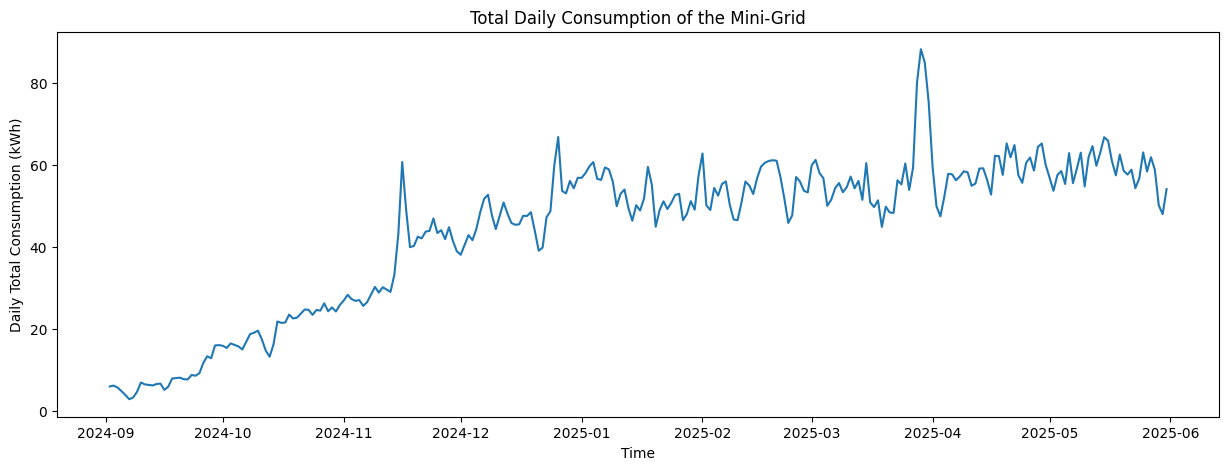

In [50]:
# Calculate total consumption per day

total_daily_consumption = df.groupby('Timestamp (UTC)')['Usage Amount'].sum().reset_index()

#Plot

plt.figure(figsize=(15,5))
sns.lineplot(data=total_daily_consumption, x='Timestamp (UTC)', y='Usage Amount')
plt.title('Total Daily Consumption of the Mini-Grid')
plt.xlabel('Time')
plt.ylabel('Daily Total Consumption (kWh)')
plt.show()

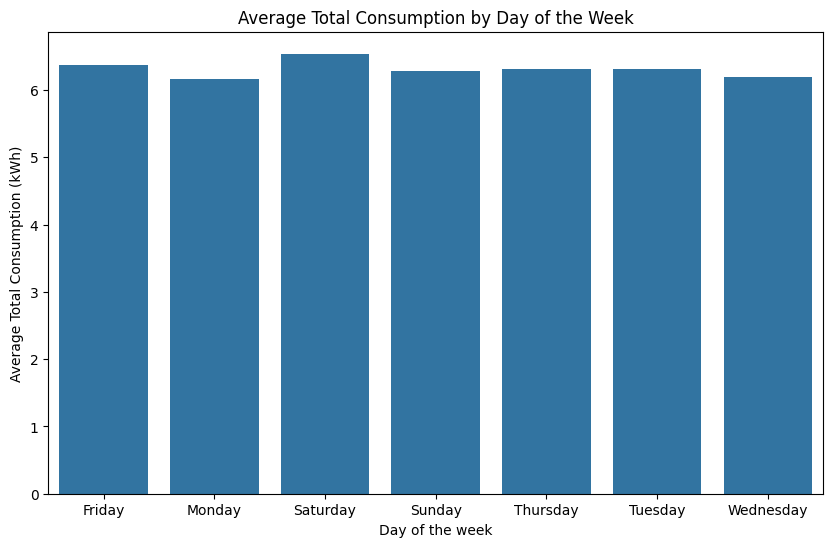

In [51]:
# Analyze comsumption by Day of the week

avg_comsumption_by_day = df.groupby('day_of_week')['Usage Amount'].sum()/df['Timestamp (UTC)'].nunique()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_comsumption_by_day.reindex(day_order)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_comsumption_by_day.index, y=avg_comsumption_by_day.values)
plt.title('Average Total Consumption by Day of the Week')
plt.xlabel('Day of the week')
plt.ylabel('Average Total Consumption (kWh)')
plt.show()

In [52]:
customer_metrics = df.groupby('Meter Number')['Usage Amount'].agg(
    avg_daily_kwh='mean',
    std_dev_kwh='std'
).reset_index()

weekend_consumption = df[df['is_weekend']].groupby('Meter Number')['Usage Amount'].mean()
weekday_consumption = df[~df['is_weekend']].groupby('Meter Number')['Usage Amount'].mean()

ratio_series = (weekend_consumption / weekday_consumption).fillna(1)

customer_metrics['weekend_weekday_ratio'] = customer_metrics['Meter Number'].map(ratio_series)

print("Customer Metrics")
customer_metrics.head(10)

Customer Metrics


,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio
0,240000029134,1.084320,0.704037,1.049797
1,240000029159,0.872797,0.233724,1.026061
2,240000029167,0.232411,0.056976,1.041951
3,240000029175,0.917712,0.499405,1.067378
4,240000029191,1.134669,1.124506,0.811102
5,240000029209,1.130843,0.236863,0.990211
6,240000029571,0.854138,0.099499,0.995210
7,240000029589,0.436366,0.118659,1.010944
8,240000029605,4.672615,1.338896,1.032495
9,240000029894,5.290332,1.558374,1.042214


In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = customer_metrics[['avg_daily_kwh','std_dev_kwh', 'weekend_weekday_ratio']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kMeans = KMeans(n_clusters=5, random_state=42, n_init=20)
customer_metrics['cluster'] = kMeans.fit_predict(features_scaled)
print("Cutomers with their assigned cluster")
customer_metrics.head()


Cutomers with their assigned cluster


,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio,cluster
0,240000029134,1.084320,0.704037,1.049797,2
1,240000029159,0.872797,0.233724,1.026061,2
2,240000029167,0.232411,0.056976,1.041951,4
3,240000029175,0.917712,0.499405,1.067378,2
4,240000029191,1.134669,1.124506,0.811102,0


In [54]:
cluster_name_map = {
    3: 'Anchor Load',
    0: 'Power Household',
    2: 'Standard Household',
    4: 'Low Use / Business',
    1: 'Anomaly / Inactive'
}

customer_metrics['segment_name'] = customer_metrics['cluster'].map(cluster_name_map)

In [55]:
customer_metrics.head()

,Meter Number,avg_daily_kwh,std_dev_kwh,weekend_weekday_ratio,cluster,segment_name
0,240000029134,1.084320,0.704037,1.049797,2,Standard Household
1,240000029159,0.872797,0.233724,1.026061,2,Standard Household
2,240000029167,0.232411,0.056976,1.041951,4,Low Use / Business
3,240000029175,0.917712,0.499405,1.067378,2,Standard Household
4,240000029191,1.134669,1.124506,0.811102,0,Power Household


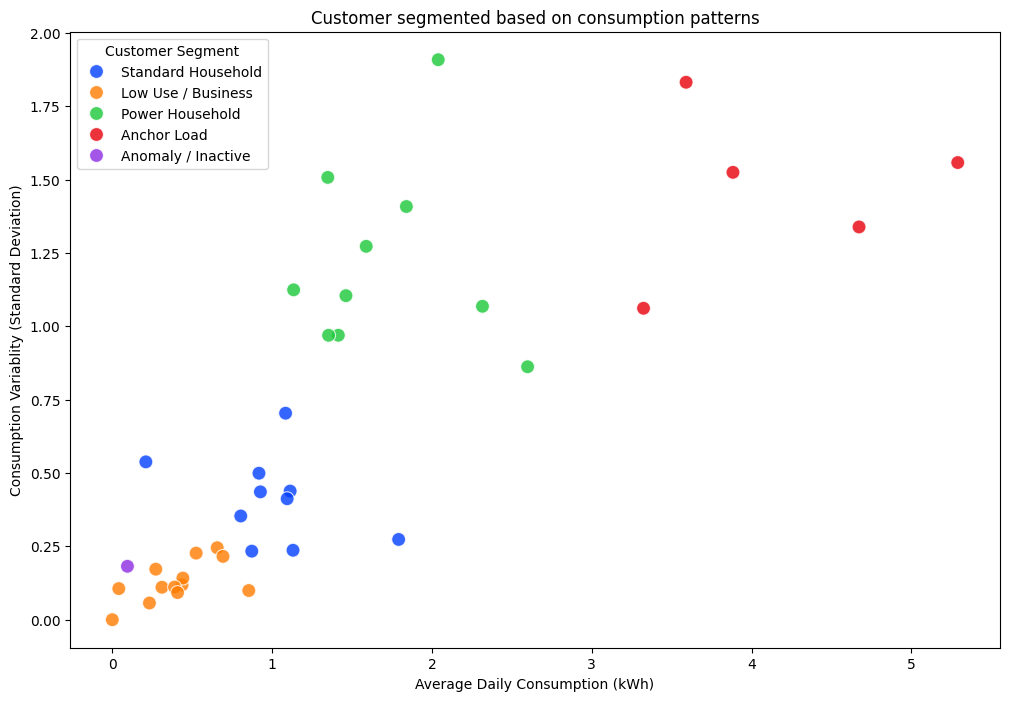

In [56]:
#visualize segments

plt.figure(figsize=(12,8))
sns.scatterplot(
    data=customer_metrics,
    x='avg_daily_kwh',
    y='std_dev_kwh',
    hue='segment_name',
    palette="bright",
    s=100,
    alpha=0.8
)
plt.title('Customer segmented based on consumption patterns')
plt.xlabel('Average Daily Consumption (kWh)')
plt.ylabel('Consumption Variablity (Standard Deviation)')
plt.legend(title='Customer Segment')
plt.show()

In [57]:
cluster_summary = customer_metrics.groupby('cluster')[['avg_daily_kwh', 'std_dev_kwh', 'weekend_weekday_ratio']].mean()
print(cluster_summary)

         avg_daily_kwh  std_dev_kwh  weekend_weekday_ratio
cluster                                                   
0             1.709627     1.219760               1.039171
1             0.094718     0.182210               3.895136
2             0.994488     0.412625               1.102708
3             4.152227     1.463249               1.004646
4             0.404610     0.130649               1.001252


In [58]:
data_loader_hour = Load_Dataset("2025.06 (1).csv")
dfh = data_loader_hour.load_data()
dfh.shape

(142776, 3)

In [59]:
dfh['Timestamp (UTC)'] = pd.to_datetime(dfh['Timestamp (UTC)']).dt.tz_localize(None).dt.strftime('%Y-%m-%d %H:%M')

print(dfh['Timestamp (UTC)'].head(10))

0    2024-10-15 09:00
1    2024-10-15 10:00
2    2024-10-15 11:00
3    2024-10-15 12:00
4    2024-10-15 13:00
5    2024-10-15 14:00
6    2024-10-15 15:00
7    2024-10-15 16:00
8    2024-10-15 17:00
9    2024-10-15 18:00
Name: Timestamp (UTC), dtype: object


In [60]:
dfh['Timestamp (UTC)'] = pd.to_datetime(dfh['Timestamp (UTC)']).dt.tz_localize(None)

In [61]:
dfh['Timestamp (UTC)']

0        2024-10-15 09:00:00
1        2024-10-15 10:00:00
2        2024-10-15 11:00:00
3        2024-10-15 12:00:00
4        2024-10-15 13:00:00
                 ...        
142771   2025-05-31 07:00:00
142772   2025-05-31 08:00:00
142773   2025-05-31 09:00:00
142774   2025-05-31 10:00:00
142775   2025-05-31 11:00:00
Name: Timestamp (UTC), Length: 142776, dtype: datetime64[ns]

In [62]:
len(dfh['Meter Number'].unique())

36

In [63]:
dfh['Hour'] = dfh['Timestamp (UTC)'].dt.hour
dfh['is_weekend'] = dfh['Timestamp (UTC)'].dt.dayofweek >= 5

total_hourly_load = dfh.groupby(['Timestamp (UTC)', 'Hour', 'is_weekend'])['Usage Amount'].sum().reset_index()

avg_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour'])['Usage Amount'].mean().unstack(level=0)
avg_load_profile.columns = ['Weekday', 'Weekend']

C:\Users\EEK\AppData\Local\Temp\ipykernel_6728\3277826617.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour_bin'])['Usage Amount'].mean().unstack(level=0)


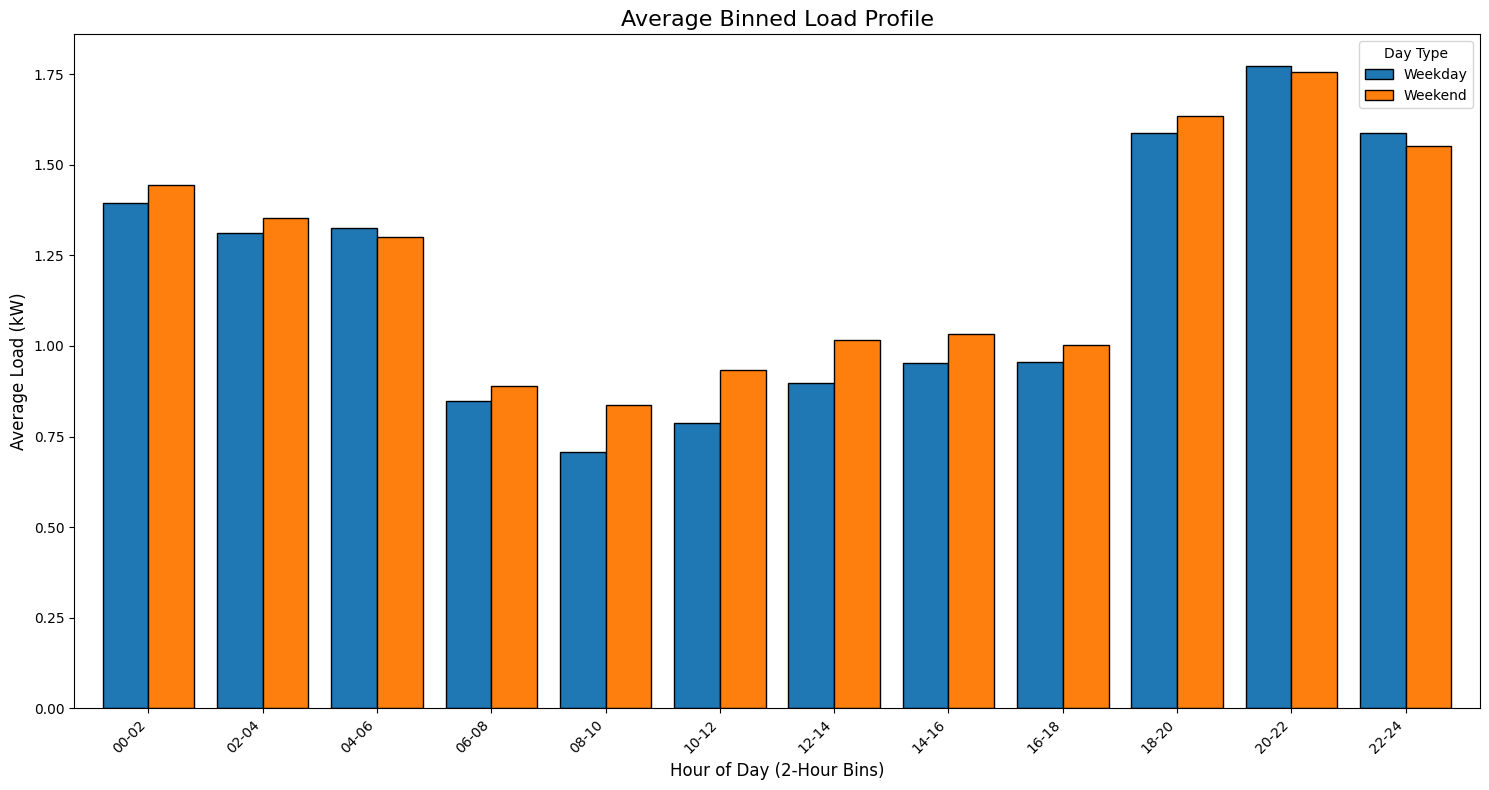

In [64]:
bins = range(0,25,2)
labels =[f"{i:02d}-{i+2:02d}" for i in bins[:-1]]

total_hourly_load['Hour_bin'] = pd.cut(total_hourly_load['Hour'], bins=bins, labels=labels, right=False)

binned_load_profile = total_hourly_load.groupby(['is_weekend', 'Hour_bin'])['Usage Amount'].mean().unstack(level=0)
binned_load_profile.columns = ['Weekday', 'Weekend']

binned_load_profile.plot(
    kind='bar',
    figsize=(15, 8),
    width=0.8, # Adjust the width of the bars
    edgecolor='black'
)

plt.title('Average Binned Load Profile', fontsize=16)
plt.xlabel('Hour of Day (2-Hour Bins)', fontsize=12)
plt.ylabel('Average Load (kW)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()

In [65]:
unique_meters = dfh['Meter Number'].nunique()

print(f"The DataFrame 'dfh' contains data for {unique_meters} unique meter(s).")

The DataFrame 'dfh' contains data for 36 unique meter(s).


In [66]:
avg_profiles_df = dfh.groupby(['Meter Number', 'Hour'])['Usage Amount'].mean().unstack()
avg_profiles_df

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Meter Number,,,,,,,,,,,,,,,,,,,,,
240000029134,0.047855,0.046385,0.047089,0.047271,0.046747,0.046782,0.016820,0.004607,0.003093,0.002563,...,0.003816,0.003132,0.003893,0.006196,0.040797,0.048954,0.047840,0.048465,0.048726,0.049979
240000029159,0.062212,0.060001,0.060910,0.060298,0.060559,0.056589,0.009476,0.003740,0.002432,0.001977,...,0.001929,0.002960,0.004130,0.004291,0.060774,0.070695,0.068444,0.064412,0.064259,0.062337
240000029167,0.016287,0.015322,0.013779,0.013746,0.013113,0.016068,0.005302,0.003810,0.002831,0.001830,...,0.001565,0.003710,0.002753,0.004276,0.015970,0.021046,0.021912,0.019101,0.016924,0.016530
240000029175,0.034947,0.034920,0.034398,0.034634,0.034520,0.034393,0.016430,0.005782,0.004164,0.002690,...,0.001789,0.001568,0.002319,0.002749,0.025502,0.032977,0.034382,0.036892,0.036011,0.035881
240000029191,0.000096,0.000003,0.000092,0.000003,0.000000,0.000370,0.001483,0.001536,0.003457,0.003489,...,0.001770,0.001942,0.001603,0.002459,0.002197,0.001174,0.000393,0.000286,0.000191,0.000188
240000029209,0.055910,0.053880,0.055806,0.054568,0.058780,0.058744,0.031383,0.032691,0.029356,0.025619,...,0.031346,0.024814,0.025667,0.029590,0.089429,0.108741,0.097724,0.073216,0.062685,0.056321
240000029571,0.070605,0.070627,0.069724,0.070267,0.070089,0.067508,0.029570,0.005791,0.004128,0.003584,...,0.005044,0.002950,0.002641,0.004330,0.045991,0.068142,0.070788,0.071297,0.071367,0.071254
240000029589,0.037397,0.034929,0.036356,0.035035,0.034361,0.030964,0.010988,0.004364,0.001965,0.003673,...,0.001007,0.000966,0.001275,0.000984,0.022597,0.036552,0.038322,0.036305,0.036257,0.036925
240000029605,0.136465,0.133792,0.129649,0.129826,0.128711,0.133645,0.140228,0.144508,0.132355,0.123640,...,0.114174,0.113955,0.116618,0.124301,0.177715,0.203290,0.193218,0.166382,0.146531,0.138529


In [67]:
epsilon = 1e-6
profiles_normalized = avg_profiles_df.div(avg_profiles_df.sum(axis=1) + epsilon, axis=0)

print("---Normalized Hourly Profiles ---")
profiles_normalized

---Normalized Hourly Profiles ---


Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Meter Number,,,,,,,,,,,,,,,,,,,,,
240000029134,0.076861,0.074499,0.075631,0.075923,0.075082,0.075138,0.027015,0.007400,0.004968,0.004116,...,0.006129,0.005030,0.006252,0.009952,0.065525,0.078627,0.076837,0.077841,0.078260,0.080272
240000029159,0.078604,0.075809,0.076958,0.076186,0.076514,0.071499,0.011973,0.004726,0.003072,0.002498,...,0.002437,0.003740,0.005218,0.005421,0.076786,0.089322,0.086478,0.081383,0.081189,0.078762
240000029167,0.069733,0.065600,0.058994,0.058855,0.056144,0.068796,0.022700,0.016313,0.012121,0.007835,...,0.006702,0.015884,0.011788,0.018307,0.068375,0.090108,0.093816,0.081779,0.072461,0.070771
240000029175,0.076982,0.076922,0.075774,0.076292,0.076041,0.075761,0.036193,0.012738,0.009172,0.005926,...,0.003941,0.003453,0.005109,0.006055,0.056177,0.072642,0.075739,0.081268,0.079327,0.079039
240000029191,0.002947,0.000080,0.002810,0.000078,0.000000,0.011339,0.045403,0.047020,0.105803,0.106777,...,0.054184,0.059433,0.049066,0.075264,0.067237,0.035948,0.012017,0.008755,0.005847,0.005746
240000029209,0.048249,0.046498,0.048160,0.047091,0.050727,0.050696,0.027083,0.028212,0.025334,0.022109,...,0.027051,0.021414,0.022150,0.025536,0.077176,0.093842,0.084335,0.063184,0.054096,0.048604
240000029571,0.079562,0.079586,0.078569,0.079182,0.078980,0.076072,0.033321,0.006525,0.004651,0.004039,...,0.005684,0.003324,0.002976,0.004880,0.051826,0.076787,0.079769,0.080342,0.080421,0.080293
240000029589,0.082666,0.077212,0.080366,0.077446,0.075956,0.068447,0.024288,0.009647,0.004343,0.008120,...,0.002225,0.002135,0.002819,0.002175,0.049952,0.080799,0.084712,0.080252,0.080146,0.081624
240000029605,0.041823,0.041004,0.039734,0.039789,0.039447,0.040959,0.042977,0.044288,0.040564,0.037893,...,0.034991,0.034924,0.035741,0.038095,0.054465,0.062304,0.059217,0.050992,0.044908,0.042456


In [68]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

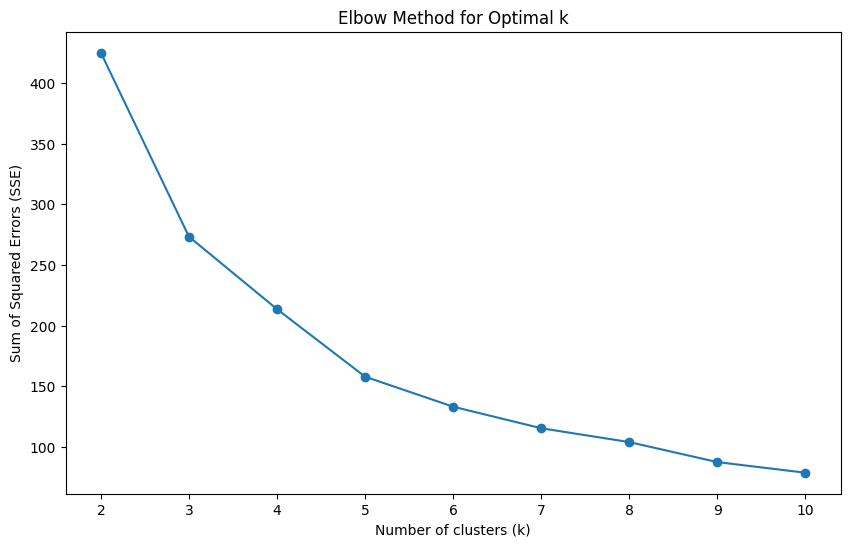

In [69]:
x = profiles_normalized.values

scaler = StandardScaler()
x_scaled = scaler .fit_transform(x)

sse = {}
for k in range(2,11):
    kMeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(x_scaled)
    sse[k] = kMeans.inertia_

plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [70]:
OPTIMAL_K = 5

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(x_scaled)

profiles_normalized['behavioral_cluster'] = clusters

print(f"\nSuccessfully segmented customers into {OPTIMAL_K} behavioral clusters.")


Successfully segmented customers into 5 behavioral clusters.


In [71]:
avg_profiles_df['behavioral_cluster'] = clusters

cluster_profile = avg_profiles_df.groupby('behavioral_cluster').mean()

cluster_profile

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
behavioral_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.041930,0.041043,0.041123,0.040931,0.040774,0.038700,0.013050,0.004360,0.002949,0.002648,...,0.002938,0.002839,0.003122,0.003712,0.029858,0.042778,0.044271,0.043830,0.043159,0.042600
1,0.106637,0.102044,0.098378,0.096093,0.097071,0.106050,0.086032,0.078857,0.076186,0.076776,...,0.095003,0.094823,0.093614,0.094960,0.122234,0.140419,0.141357,0.134055,0.121630,0.112838
2,0.000096,0.000003,0.000092,0.000003,0.000000,0.000370,0.001483,0.001536,0.003457,0.003489,...,0.001770,0.001942,0.001603,0.002459,0.002197,0.001174,0.000393,0.000286,0.000191,0.000188
3,0.044151,0.042374,0.041904,0.040813,0.044732,0.042172,0.023956,0.014657,0.011303,0.010192,...,0.014079,0.012671,0.012969,0.014795,0.038036,0.048938,0.052230,0.049896,0.048966,0.046467
4,0.001532,0.001238,0.001197,0.000715,0.000492,0.000434,0.000358,0.001106,0.007281,0.016515,...,0.000993,0.001152,0.001081,0.001047,0.001984,0.006131,0.005750,0.002625,0.001914,0.001446


In [72]:
behavioral_name_map = {
    1: 'Anchor Load',
    2: 'Low and Constant Use',
    3: 'Residential Evening Peak',
    0: 'Early Evening Peak',
    4: 'Daytime Business Load',
}

cluster_profile_named = cluster_profile.T.rename(columns=behavioral_name_map)

In [73]:
cluster_profile_named.head(20)

behavioral_cluster,Early Evening Peak,Anchor Load,Low and Constant Use,Residential Evening Peak,Daytime Business Load
Hour,,,,,
0,0.041930,0.106637,0.000096,0.044151,0.001532
1,0.041043,0.102044,0.000003,0.042374,0.001238
2,0.041123,0.098378,0.000092,0.041904,0.001197
3,0.040931,0.096093,0.000003,0.040813,0.000715
4,0.040774,0.097071,0.000000,0.044732,0.000492
5,0.038700,0.106050,0.000370,0.042172,0.000434
6,0.013050,0.086032,0.001483,0.023956,0.000358
7,0.004360,0.078857,0.001536,0.014657,0.001106
8,0.002949,0.076186,0.003457,0.011303,0.007281


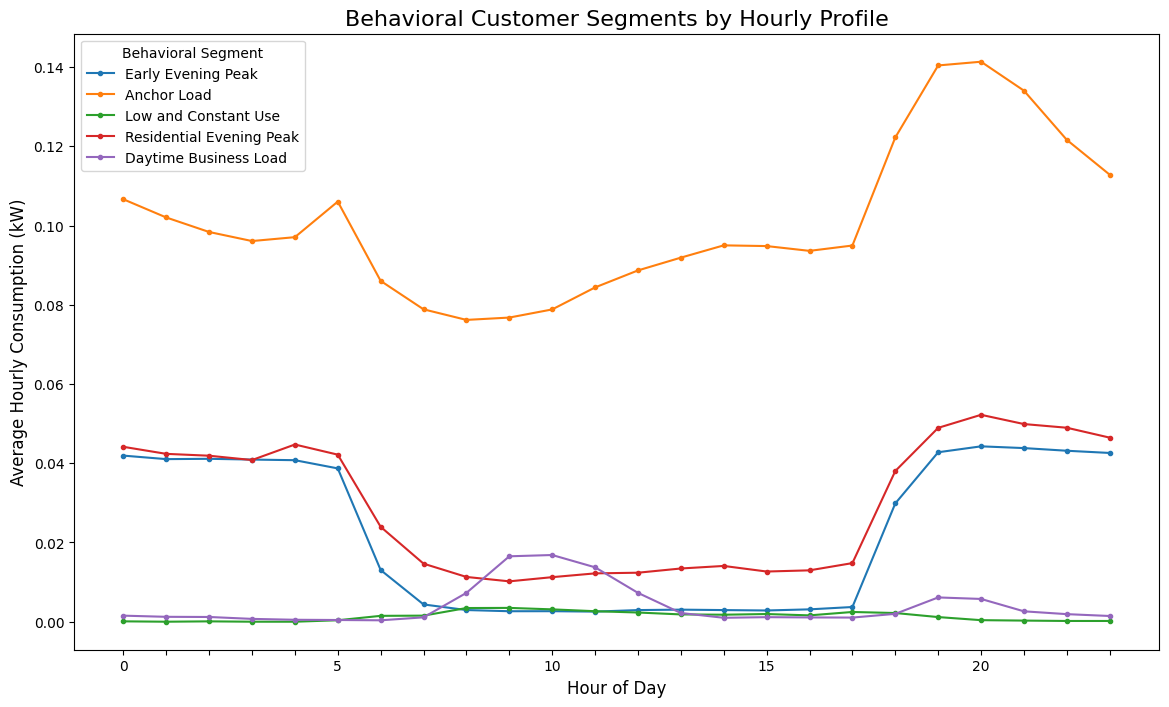

In [74]:
cluster_profile_named.plot(figsize=(14, 8), marker='.')

plt.title('Behavioral Customer Segments by Hourly Profile', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Hourly Consumption (kW)', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Behavioral Segment')
plt.show()

In [75]:
customer_counts = avg_profiles_df.groupby('behavioral_cluster').size()
customer_counts

behavioral_cluster
0    10
1    14
2     1
3    10
4     1
dtype: int64

In [76]:
segment_total_kwh = avg_profiles_df.groupby('behavioral_cluster').sum().sum(axis=1)
segment_total_kwh

behavioral_cluster
0     5.378114
1    33.863951
2     0.032670
3     7.045606
4     0.095046
dtype: float64

In [77]:
# 3. Combine these into a single summary DataFrame.
segment_analysis = pd.DataFrame({
    'customer_count': customer_counts,
    'total_avg_daily_kwh': segment_total_kwh
})

# 4. Calculate the percentage of total consumption for each segment.
segment_analysis['percentage_of_total_kwh'] = (segment_analysis['total_avg_daily_kwh'] / segment_analysis['total_avg_daily_kwh'].sum()) * 100

# 5. (Optional but recommended) Map the names for a final, clean table.
#    Use the 'behavioral_name_map' you defined in the previous step.
segment_analysis.index = segment_analysis.index.map(behavioral_name_map)

print("--- Analysis of Behavioral Segments ---")
behavioural_segment_analysis = segment_analysis.sort_values(by='percentage_of_total_kwh', ascending=False)
behavioural_segment_analysis

--- Analysis of Behavioral Segments ---


,customer_count,total_avg_daily_kwh,percentage_of_total_kwh
behavioral_cluster,,,
Anchor Load,14,33.863951,72.958461
Residential Evening Peak,10,7.045606,15.179462
Early Evening Peak,10,5.378114,11.586920
Daytime Business Load,1,0.095046,0.204772
Low and Constant Use,1,0.032670,0.070386


In [114]:
total_hourly_load = total_hourly_load[total_hourly_load['Timestamp (UTC)'].dt.month != 9]

In [116]:
total_hourly_load.reset_index(inplace=True)

In [118]:
total_hourly_load.drop(columns='index', inplace=True)
total_hourly_load

C:\Users\EEK\AppData\Local\Temp\ipykernel_6728\3353728865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_hourly_load.drop(columns='index', inplace=True)


,Timestamp (UTC),Hour,is_weekend,Usage Amount,Hour_bin
0,2024-10-01 00:00:00,0,False,1.061319,00-02
1,2024-10-01 01:00:00,1,False,1.075878,00-02
2,2024-10-01 02:00:00,2,False,1.036809,02-04
3,2024-10-01 03:00:00,3,False,0.976452,02-04
4,2024-10-01 04:00:00,4,False,1.016479,04-06
...,...,...,...,...,...
5815,2025-05-31 07:00:00,7,True,0.570908,06-08
5816,2025-05-31 08:00:00,8,True,0.650931,08-10
5817,2025-05-31 09:00:00,9,True,0.775697,08-10
5818,2025-05-31 10:00:00,10,True,1.055457,10-12


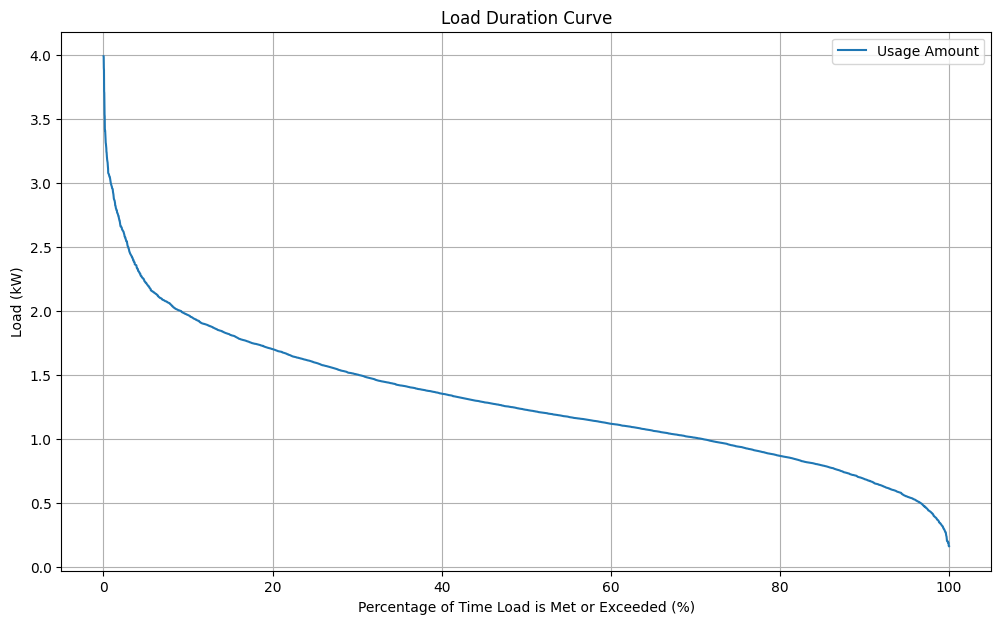

In [ ]:
sorted_load = total_hourly_load['Usage Amount'].sort_values(ascending=False).reset_index(drop=True)

sorted_load_df = sorted_load.to_frame()
sorted_load_df['percentage_of_time'] = (sorted_load_df.index + 1) * 100 / len(sorted_load_df)

# 3. Plot the Load Duration Curve
sorted_load_df.plot(x='percentage_of_time', y='Usage Amount', figsize=(12, 7))
plt.title('Load Duration Curve')
plt.xlabel('Percentage of Time Load')
plt.ylabel('Load (kW)')
plt.grid(True)
plt.show()

In [146]:
total_hourly_load.set_index('Timestamp (UTC)', inplace=True)

In [147]:
total_hourly_load['day_name'] = total_hourly_load.index.day_name()
total_hourly_load['hour'] = total_hourly_load.index.hour

C:\Users\EEK\AppData\Local\Temp\ipykernel_6728\1748320100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_hourly_load['day_name'] = total_hourly_load.index.day_name()
C:\Users\EEK\AppData\Local\Temp\ipykernel_6728\1748320100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_hourly_load['hour'] = total_hourly_load.index.hour


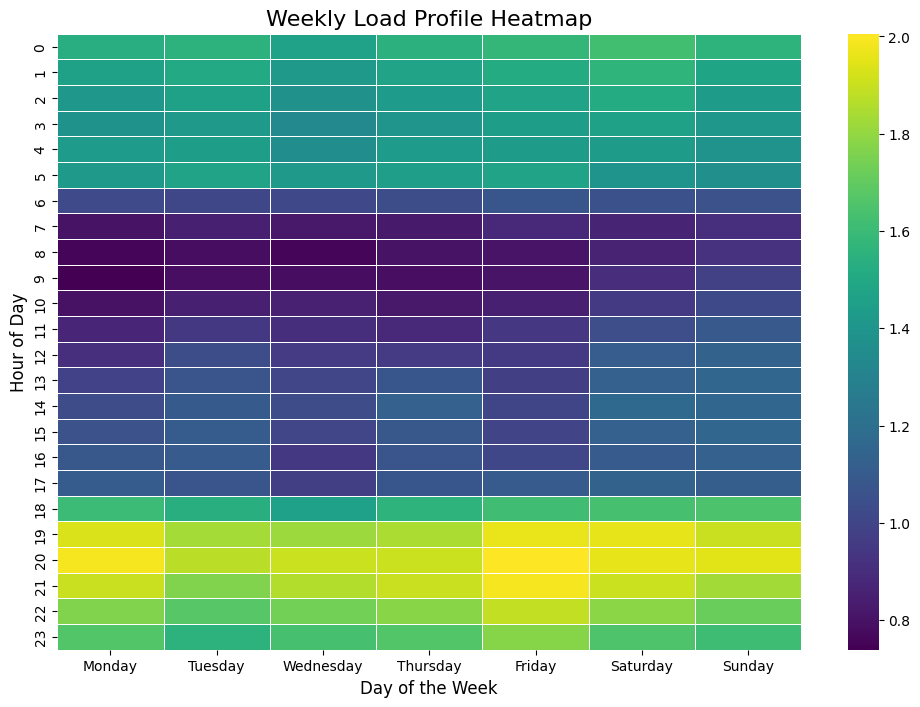

In [149]:
weekly_heatmap_data = total_hourly_load.pivot_table(
    values='Usage Amount', 
    index='hour', 
    columns='day_name', 
    aggfunc='mean'
)

# 3. Order the columns correctly (Monday to Sunday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_heatmap_data = weekly_heatmap_data[day_order]

# 4. Create the heatmap plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    weekly_heatmap_data, 
    cmap='viridis', # 'viridis', 'plasma', or 'inferno' are good choices
    annot=False, # Set to True if you want to see the numbers, but can be messy
    linewidths=.5
)
plt.title('Weekly Load Profile Heatmap', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.show()

In [150]:
customer_daily_avg = avg_profiles_df.sum(axis=1)

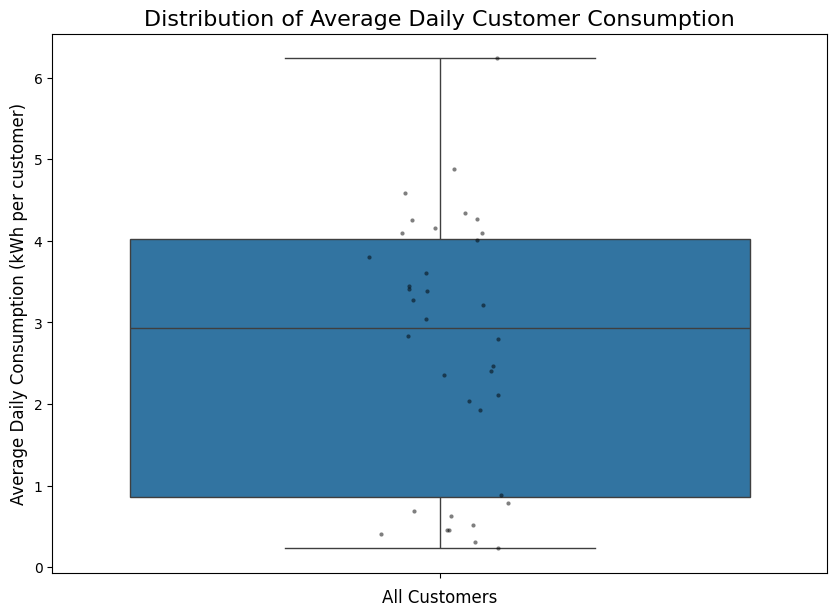

count    36.000000
mean      2.678205
std       1.596073
min       0.233565
25%       0.863432
50%       2.937728
75%       4.026968
max       6.238208
dtype: float64


In [153]:
plt.figure(figsize=(10, 7))
sns.boxplot(y=customer_daily_avg)
sns.stripplot(y=customer_daily_avg, color='black', size=3, alpha=0.5) # Overlay individual customer points

plt.title('Distribution of Average Daily Customer Consumption', fontsize=16)
plt.ylabel('Average Daily Consumption (kWh per customer)', fontsize=12)
plt.xlabel('All Customers', fontsize=12)
plt.show()

# 3. Print summary statistics to quantify the finding
print(customer_daily_avg.describe())

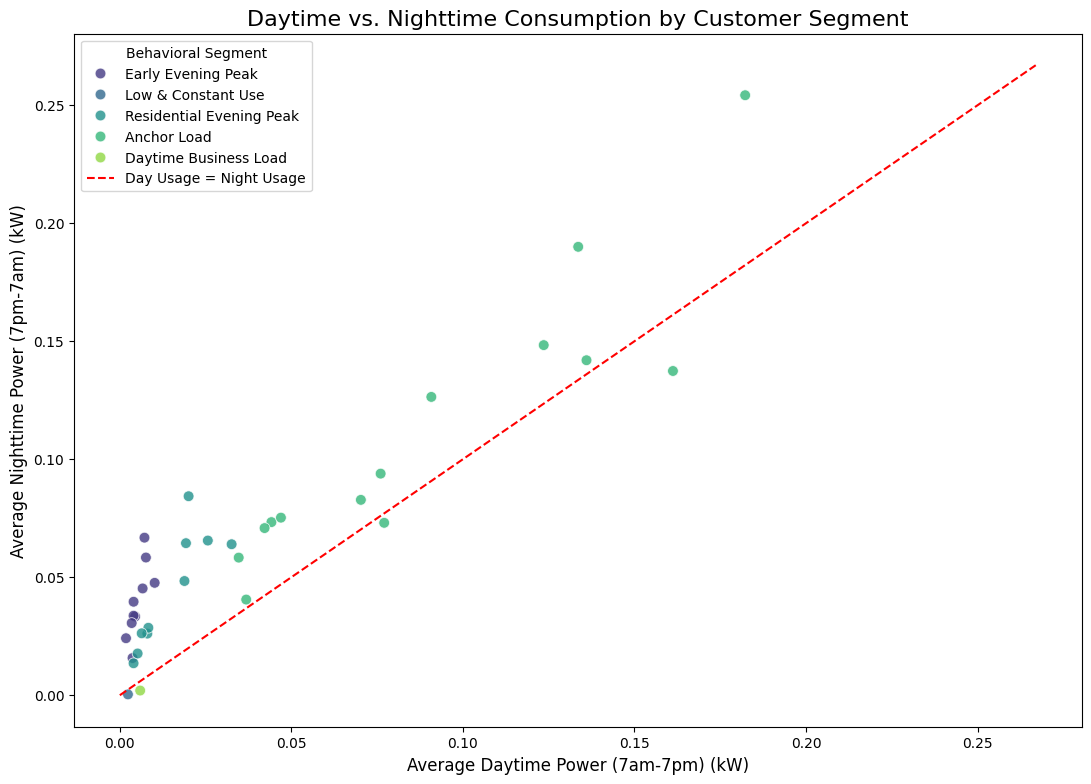

In [156]:
behavioral_name_map = {
    1: 'Anchor Load',
    3: 'Residential Evening Peak',
    0: 'Early Evening Peak',
    4: 'Daytime Business Load',
    2: 'Low & Constant Use'
}

# --- 2. Define day and night hours ---
day_hours = range(7, 19)   # 7 AM to 6 PM (18:00)
night_hours = [h for h in range(24) if h not in day_hours]

# --- 3. Calculate average consumption during day and night for each customer ---
day_consumption = avg_profiles_df[day_hours].mean(axis=1)
night_consumption = avg_profiles_df[night_hours].mean(axis=1)

# --- 4. Create a new dataframe for plotting ---
scatter_df = pd.DataFrame({
    'day_avg_kw': day_consumption,
    'night_avg_kw': night_consumption,
    'cluster_number': avg_profiles_df['behavioral_cluster'] # Keep the original number for mapping
})

# --- 5. MAP THE CLUSTER NUMBERS TO THE DESCRIPTIVE NAMES (THE KEY FIX) ---
scatter_df['Segment'] = scatter_df['cluster_number'].map(behavioral_name_map)


# --- 6. Create the scatter plot with the new names ---
plt.figure(figsize=(13, 9)) # Made it slightly bigger for the longer legend names
sns.scatterplot(
    data=scatter_df, 
    x='day_avg_kw', 
    y='night_avg_kw',
    hue='Segment',  # <-- Use the new 'Segment' column for the legend
    palette='viridis', # Or another palette like 'deep', 'muted', 'bright'
    s=60, 
    alpha=0.8
)

# Add a diagonal line for reference (y=x)
max_val = max(scatter_df['day_avg_kw'].max(), scatter_df['night_avg_kw'].max()) * 1.05 # Add 5% padding
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Day Usage = Night Usage')

plt.title('Daytime vs. Nighttime Consumption by Customer Segment', fontsize=16)
plt.xlabel('Average Daytime Power (7am-7pm) (kW)', fontsize=12)
plt.ylabel('Average Nighttime Power (7pm-7am) (kW)', fontsize=12)
plt.legend(title='Behavioral Segment', fontsize=10)
plt.show()

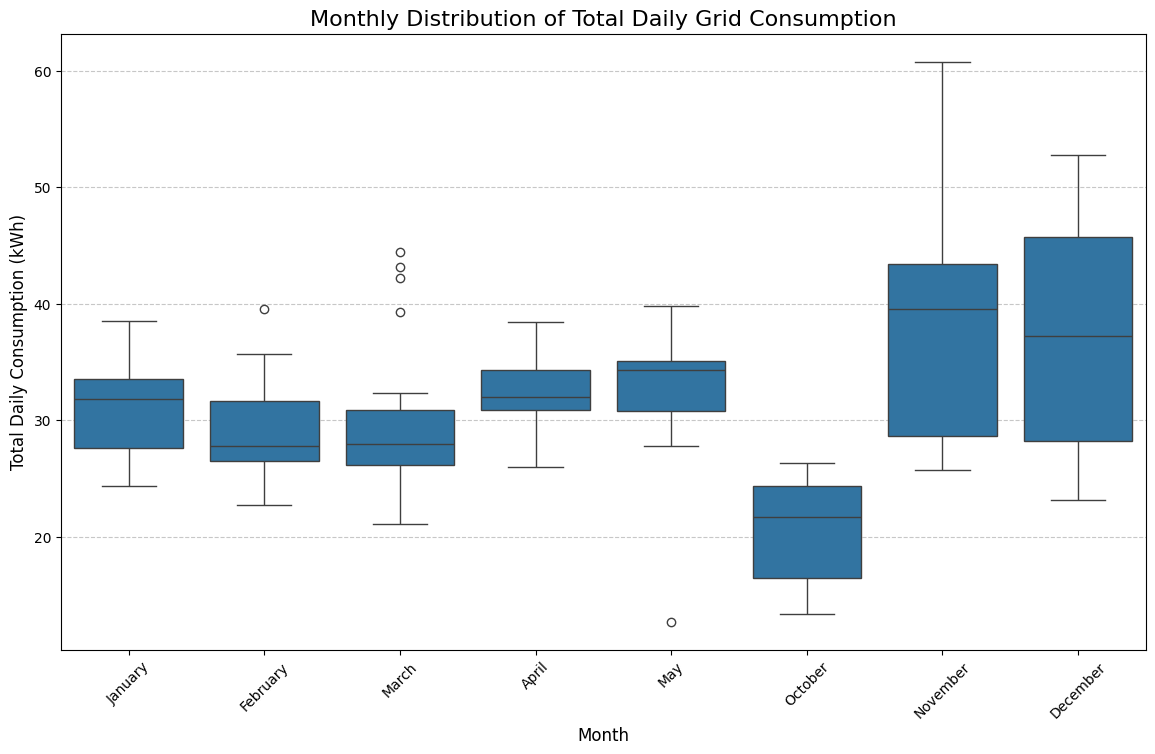

In [157]:
daily_consumption = total_hourly_load['Usage Amount'].resample('D').sum()
daily_consumption_df = daily_consumption.to_frame()

# 2. Add month name and number for proper sorting
daily_consumption_df['month_name'] = daily_consumption_df.index.month_name()
daily_consumption_df['month_num'] = daily_consumption_df.index.month

# 3. Sort by month number to ensure correct order in the plot
daily_consumption_df.sort_values('month_num', inplace=True)

# 4. Create the box plot
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=daily_consumption_df,
    x='month_name',
    y='Usage Amount'
)
plt.title('Monthly Distribution of Total Daily Grid Consumption', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Daily Consumption (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\EEK\AppData\Local\Temp\ipykernel_6728\1569693019.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_lf['load_factor'].fillna(0, inplace=True)


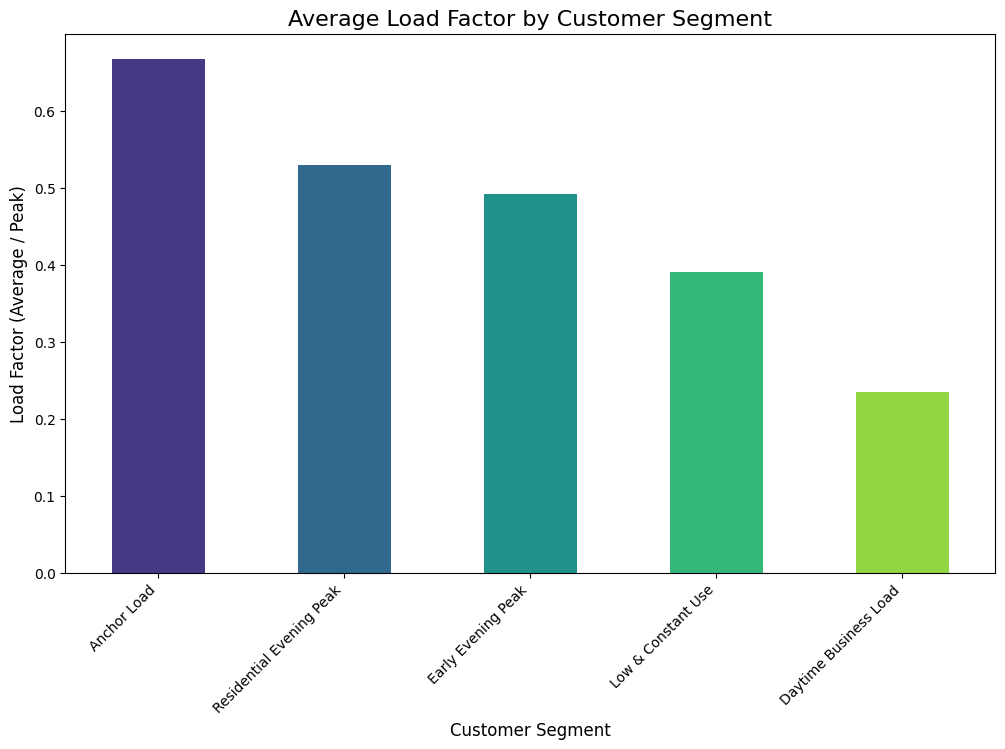

In [160]:
customer_lf = avg_profiles_df.copy()
customer_lf['peak_kw'] = customer_lf.loc[:, 0:23].max(axis=1)
customer_lf['average_kw'] = customer_lf.loc[:, 0:23].mean(axis=1)

# 2. Calculate Load Factor for each customer. Avoid division by zero for zero-consumption users.
customer_lf['load_factor'] = customer_lf['average_kw'] / customer_lf['peak_kw']
customer_lf['load_factor'].fillna(0, inplace=True)

# 3. Use your name map to get descriptive segment names
customer_lf['Segment'] = customer_lf['behavioral_cluster'].map(behavioral_name_map)

# 4. Calculate the average load factor for each segment
segment_load_factors = customer_lf.groupby('Segment')['load_factor'].mean().sort_values(ascending=False)

# 5. Create the bar chart
plt.figure(figsize=(12, 7))
segment_load_factors.plot(kind='bar', color=sns.color_palette('viridis', len(segment_load_factors)))
plt.title('Average Load Factor by Customer Segment', fontsize=16)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Load Factor (Average / Peak)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


In [161]:
dfh.columns

Index(['Timestamp (UTC)', 'Meter Number', 'Usage Amount', 'Hour',
       'is_weekend'],
      dtype='object')